# 从博客看美国政治极化（2004）

在美国政治的语境下，“极化”（polarization）是指民主/共和党或者说自由/保守派的双方，其观点越发对立，以至于互相敌视、无法达成共识的状况。传统博弈论认为，在民主政体里中，越是中立的政客越可能得到更多选票（即中位投票者定律）。但是，在一个极化的社会中，很多时候立场越极端的政客反而越有影响力。因此，政治的极化一直以来都是美国社会科学研究的热点。本案例所引用的文献，从计算社会网络分析的角度对政治极化做了经典刻画 。作者在2004年美国大选期间，收集了1天内的1000多篇政治博文 作为对网络讨论整体网的一个“快照”。以政治博客的网站为节点，以网站之间的超链接为邻边，作者构建了一个博客网络，描绘了人们是如何在当时的社交网络中互动和交流政治议题的。他们发现，自由派和保守派几乎只在自己派系内部交流，而且保守派之间的沟通更频繁，集聚密度更大。他们用GUESS软件绘制的博客领域（Blogosphere）网络图，鲜明地呈现了美国网络世界的政治极化现象，成为计算社会科学的经典之一。

需要说明的是，作者在研究中采取了自由/保守派的划分，而不是民主党和共和党，因为前者可以更准确地概括研究对象。两党的意识形态在历史沿革中都经历了变迁，但是近几十年来民主党以自由派（liberals）为主 ，共和党以保守派（conservatives）为主。在根据博客内容的政治倾向进行分类时，我们仅以自由/保守派划分。

文章引用：Lada A. Adamic and Natalie Glance. 2005. The political blogosphere and the 2004 U.S. election: divided they blog. In Proceedings of the 3rd international workshop on Link discovery (LinkKDD '05). Association for Computing Machinery, New York, NY, USA, 36–43. DOI:https://doi.org/10.1145/1134271.1134277

In [1]:
import numpy as np # numpy包可以帮忙简化数据处理的过程
import matplotlib.pyplot as plt # 为了作图
from collections import Counter # Counter(列表)可以用来统计列表中元素的频次
import networkx as nx # Python用来进行网络分析的包

## 获取数据
`blogosphere`数据可以直接从R的gsbm包中获取。在此，我们先从R中提取数据（见下面的R码），把它们保存以txt格式保存。其中，A是这些blog的邻接矩阵，names是每个节点对应的网址，opinion是作者标注的每个节点属于保守派（1）还是自由派（0）。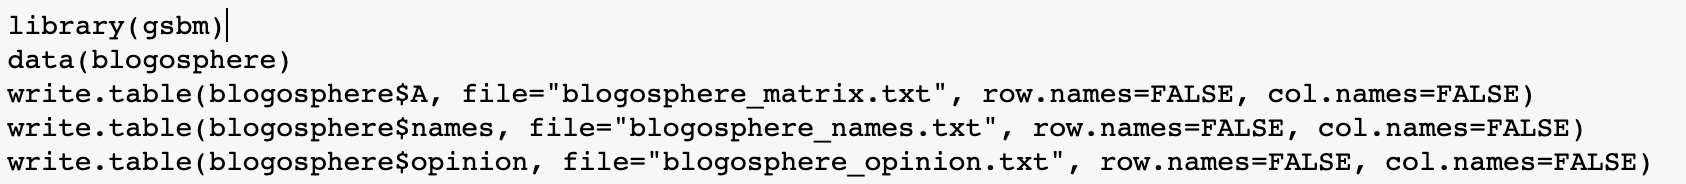

在获取数据之后，我们再用Python读取数据。在Python里，用numpy可以直接读入邻接矩阵。值得注意的是，dtype需设定为integer，否则默认为float格式，产生数据读取错误。

In [2]:
adjacency_matrix = np.loadtxt("blogosphere_matrix.txt", dtype='i', delimiter=' ')
adjacency_matrix, adjacency_matrix.shape

(array([[0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 (1222, 1222))

我们用Counter函数进行计数。结果显示，数据中共有586个自由派和636个保守派网站。

In [3]:
opinions = np.loadtxt("blogosphere_opinion.txt", dtype='i', delimiter=' ')
opinions, Counter(opinions)

(array([0, 0, 0, ..., 1, 1, 1], dtype=int32), Counter({0: 586, 1: 636}))

## 创建图和处理数据

我们利用from_numpy_matrix直接导入邻接矩阵，创建一个DiGraph（有向图）。create_using默认是无向图，而网站链接具有方向性，故我们需要创建一个有向图。

In [4]:
G = nx.from_numpy_matrix(adjacency_matrix, create_using=nx.DiGraph())
nx.info(G) 

'DiGraph with 1222 nodes and 33428 edges'

从opinion中获取保守派和自由派的节点信息

In [5]:
liberals = np.where(opinions==0)[0]
conservatives = np.where(opinions==1)[0]

遍历所有邻边，将它们分成三类：1.自由派->自由派，2.保守派->保守派，3.自由派->保守派 或者 保守派->自由派

In [6]:
liberal_edges, conservative_edges, cross_edges = [], [], []
for (v1, v2) in G.edges():
    if (v1 in liberals) and (v2 in liberals):
        liberal_edges.append((v1, v2))
    elif (v1 in conservatives) and (v2 in conservatives):
        conservative_edges.append((v1, v2))
    else:
        cross_edges.append((v1, v2))

## 画图

我们继续使用spring_layout算法生成每个节点在结果图中的位置。在案例1中，我们已经比对了不同的layout算法可视化效果的区别，在这里则介绍最常用的spring_layout算法中可能用到的参数。Spring_layout算法的大致思路是通过迭代不断调整点的位置，直到所有边的长度尽量一致的同时，让它们尽量避免交叉。但是因为大部分复杂网络都无法被转化为完全没有边重叠的平面（planar），而且这种绝对的平面也对数据分析并不很重要，我们通常会在迭代到一定的地步的时候就暂停。因此，迭代次数（iteraction）会影响最终结果。它的默认值是50，我们可以按需增减，不过赋值太大会导致运行时间过长。k则控制了节点的发散程度，默认为$1/\sqrt{n}$。我们提高了k值，以确保外围的点不至于过于发散，这使得图的结果更为突出和美观。Seed是种子，赋值之后可以使算法的每次运行结果保持一致。

In [32]:
pos = nx.spring_layout(G, iterations=50, k = 0.1, seed = 100)

下面我们计算点的入度中心度。根据原文，中心度高的点，在结果图中面积更大。在计算top_centrality的四行代码，主要目的是更准确地复现原文结果，并展现更多的可视化技巧。为了画出下图中那些黑色的“泡泡”，我们在中心度最高的600个点中随机挑选200个（这样比较能分布开）和中心度最低的500个点。对每个所选节点，我们将edgecolors设为黑色。

In [33]:
centrality = nx.algorithms.centrality.in_degree_centrality(G)

import random
top_centrality = [i[0] for i in sorted(centrality.items(), key = lambda x: -x[1])[:600]]
least_centrality = [i[0] for i in sorted(centrality.items(), key = lambda x: -x[1])[-500:]]
selected = random.sample(top_centrality, 200)+least_centrality

为了避免代码冗余，我们定义两个helper函数来简化绘制邻边和节点的流程：
* draw_edges函数用给定的颜色（color）绘制给定的边集（edges）。其中，width是边的粗细，alpha是边的透明度，在比较密集的图中，我们通常会降低边的透明度，进而在可视化中突出点的位置和特性。 
* draw_nodes函数用给定的颜色（color）绘制给定的点集（nodes），其中node_size为节点大小。由于共有1000余个节点，标准化后的centrality本身数值很小，因此我们将每个点的centrality先乘以1000再作为节点的面积。此外，对所选定的top_centrality的点，我们还想将它们的外轮廓（edgecolors）画成黑色的。

In [34]:
def draw_edges(edges, color, graph = G, position=pos):
    return nx.draw_networkx_edges(graph, position,
                                  edgelist = edges, 
                                  edge_color = color, 
                                  width = 0.3, alpha = 0.5)


def draw_nodes(nodes, color, margin=None, graph = G, position=pos):
    return nx.draw_networkx_nodes(graph, position, 
                                  nodelist = nodes, 
                                  node_color = color,
                                  node_size=[centrality[i]*1200 for i in nodes],
                                  edgecolors = margin)

完成以上步骤后，我们就可以根据类别画出所有不同颜色的邻边和节点。鉴于绘图是层层覆盖的，我们要把需要强调的图层在后面再绘制。

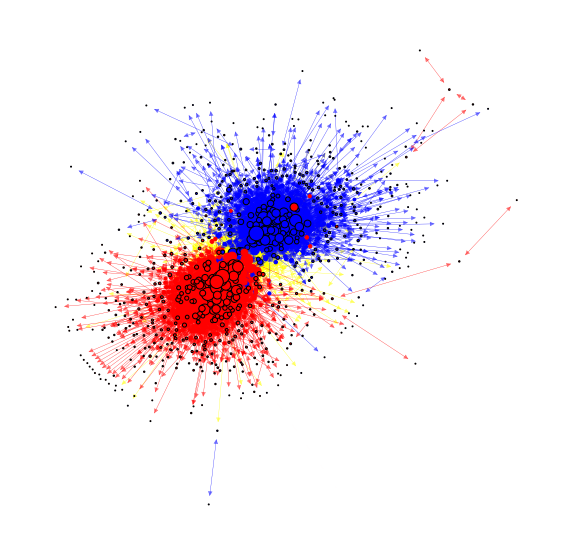

In [35]:
plt.figure(figsize=(10, 10)) # 控制图片的大小

draw_edges(cross_edges, 'yellow') 
draw_edges(conservative_edges, 'red')
draw_edges(liberal_edges, 'blue')

draw_nodes([i for i in liberals if i not in selected], 'blue')
draw_nodes([i for i in liberals if i in selected], 'blue', margin = 'black')
draw_nodes([i for i in conservatives if i not in selected], 'red')
draw_nodes([i for i in conservatives if i in selected], 'red', margin = 'black')

plt.axis('off') # 去除两个坐标轴
plt.show()

最后完成的效果与论文原图（下图）总体相似。不过，由于绘图软件不同，我们利用Python的可视化效果还存在一定差异。
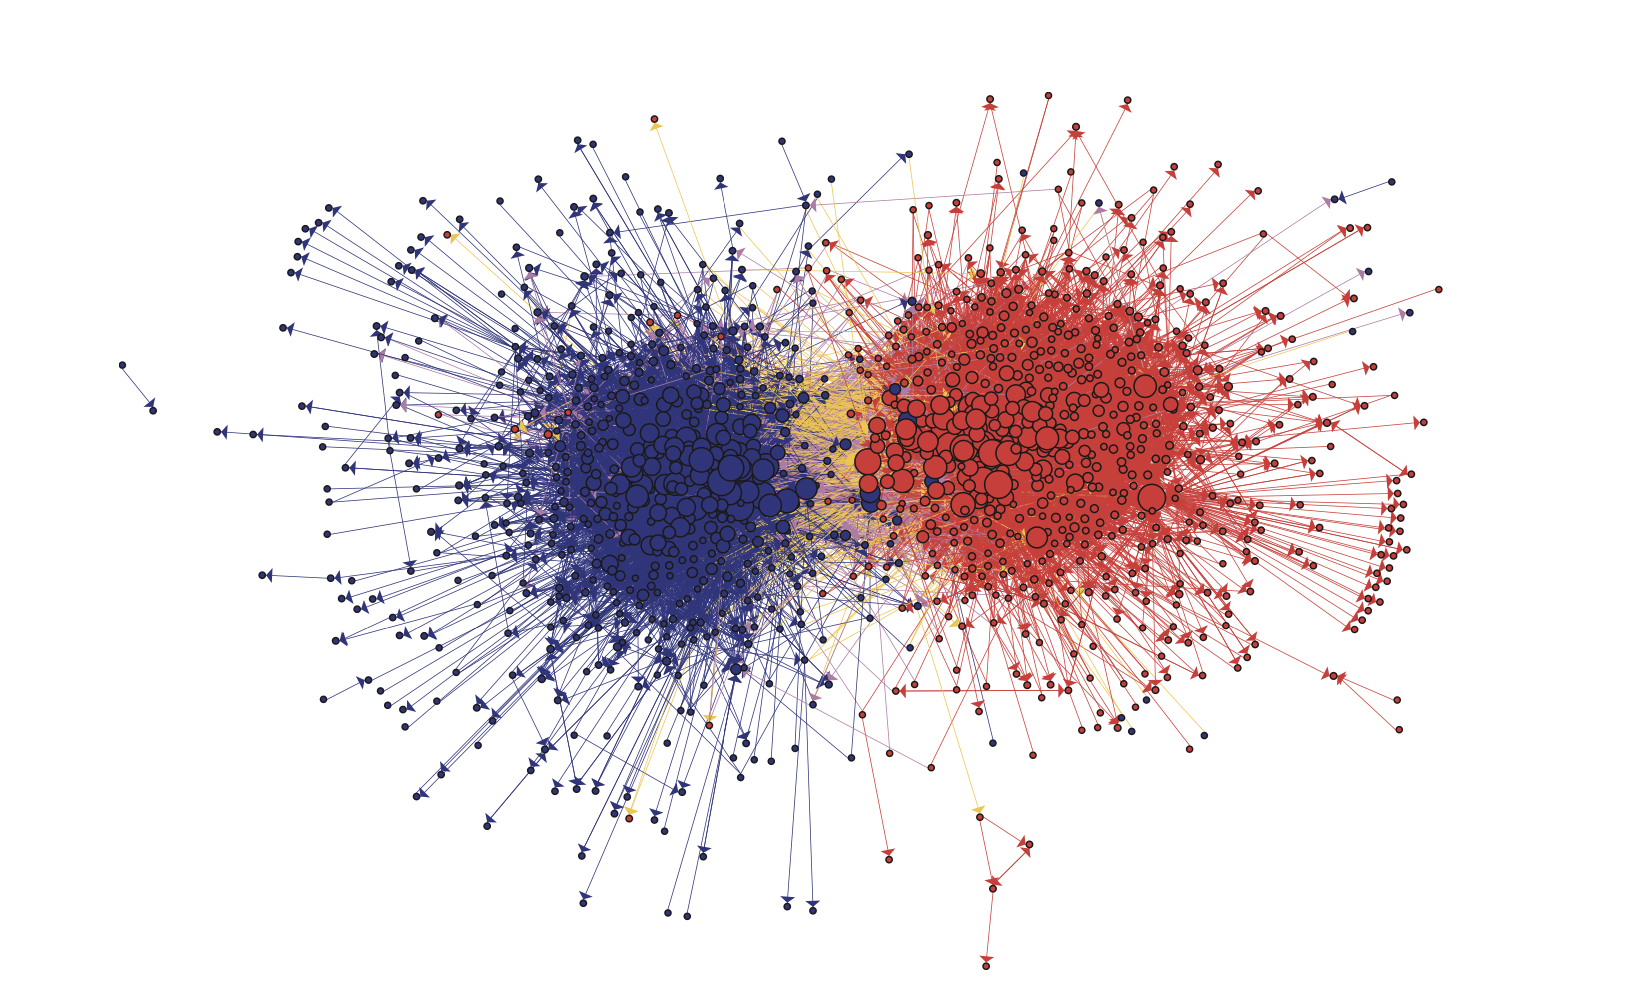

值得注意的是，我们的图中有不少红色点分布在蓝色集聚里，而蓝色点很少在红色中，这有可能是因为我们后来绘制的红点覆盖了早先画的蓝点。为了避免这种可能性，我们下面先红点后蓝点，不过蓝色的点依旧更不愿意去红色的地方，这与原图仍然不完全吻合。

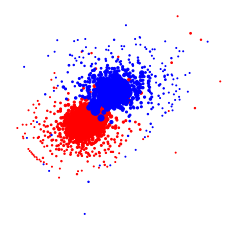

In [20]:
plt.figure(figsize=(4, 4)) 

draw_nodes(conservatives, 'red')
draw_nodes(liberals, 'blue')

plt.axis('off')
plt.show()

我们认为主要有以下两种可能的原因：其一，可能为参数设置（尤其是iteraction）所致，而且spring_layout也具有较强的随机性。其二，如原文所述，他们发现比起自由派（蓝点），保守派（红点）更爱把在博客里放上其他博客的链接——主要是其他保守派的博客，但也不乏自由派的。因此这些混迹在蓝色里的红点可能并非偶然。当然，这种绘图偏差提醒我们不可盲目通过目测（eyeballing）网络图来推出结论。网络图的可视化更多是一种参照，其效果主要取决于所选的可视化算法、参数以及随机性，而严谨的分析还必需结合量化图和节点信息。

接下来，让我们来检验该网络的“极化”程度。原文作者认为近91%的连接是保守派<->保守派或者自由派<->自由派的，我们在本案例中的确也得到了类似结果（保守派90.87%，自由派90.26%）。需要提醒读者的是，“回音壁现象”——即观念在一个闭合的系统中如同回音一般不断回响并走向极端——是一个早已突破学术圈的“热词”。与其他经典文献相似，该文作者对到底如何测量“回音壁”也尤为谨慎：他们强调，文本分析显示人们的语言习惯在集聚的内部和外部并没有很强的差异。换言之，尽管我们的确发现了一个“极化”的网络结构，但很难从给定的数据去判断政治观念是否已经完全被限制在某个集聚中。

In [11]:
num_from_consv = [v1 for (v1,v2) in G.edges() if v1 in conservatives]
print(f"{round(len(conservative_edges)/len(num_from_consv)*100, 2)}%")
num_from_liberal = [v1 for (v1,v2) in G.edges() if v1 in liberals]
print(f"{round(len(liberal_edges)/len(num_from_liberal)*100, 2)}%")

90.87%
90.26%


## 社区挖掘
现在让我们来尝试不同的社区挖掘算法。我们导入需要的算法包，并定义helper函数draw_communities。该函数对给定的图graph和分组方式p，对每个分组分配不同的颜色，并进行作图。为了与上图进行比对，我们沿用之前spring_layout算法所生成的节点位置。同时，考虑到我们已经可以在上面的图中看到邻边的分布情况，为了节省运算时间就不再画邻边。

In [12]:
from networkx.algorithms import community as cmty # 社区挖掘算法的包 
import matplotlib.cm as cm # 导入matplotlib中的色卡
import time # 可以用来计时

In [13]:
def draw_communities(graph, p):
    cmap = cm.get_cmap('prism')
    plt.figure(figsize=(8, 6)) 
    for i, group in enumerate(p):
        # 为了方便与上图进行对比，我们将最大的两个集聚（i=0,i=1）手动标注为蓝色和红色
        if i == 0: color = 'blue'
        elif i == 1: color = 'red'
        # 如果还有其他的集聚，则从cmap中按顺序提取颜色
        else: color = np.array([cmap(i/len(p))])
        nx.draw_networkx_nodes(graph, pos, # 沿用了之前的节点位置，方便比较
                               group, node_size=10, 
                               node_color=color)
    plt.axis('off')
    plt.show()

让我们从原图（有向图）开始，下面使用了较快速的Clauset-Newman-Moore Greedy Modularity算法。初步结果显示，除了比较明显的红蓝两个大集聚以外，似乎还有很多杂乱无章的小集聚。

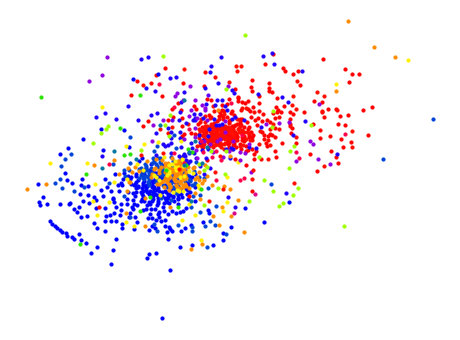

1.8109 sec
mudularity 0.30344946951113544


In [14]:
start = time.time() # 对程序所花的时间计时
partition = cmty.modularity_max.greedy_modularity_communities(G)
draw_communities(G, partition)
print(round(time.time()-start,4), "sec")
print('mudularity', cmty.modularity(G, partition)) 

当我们将原图（有向图）转化为无向图后再次使用同样算法，此时所挖掘到的集聚明显要更“整齐”。或许是因为这种“快照”式数据就像在总体中随机取了一个点，其自身的随机性很强，而有向图中计算模块度的方式对这种“噪音”更为敏感。具体而言，两个节点虽然可能在网络中位置类似，但恰好今天一个节点被连接，另一个连接了别的节点，如果用有向图的社区挖掘就更容易将它们划分到不同的集聚。

最后，除了greedy modularity算法，我们还尝试了标签传播算法 。结果表明，在这种集聚两端的分布很明显的时候，不同的算法会趋向相似的结果。此外，下文还汇报了覆盖率（coverage）和表现（performance）。

In [15]:
G_undirected = nx.from_numpy_matrix(adjacency_matrix, create_using=nx.Graph())

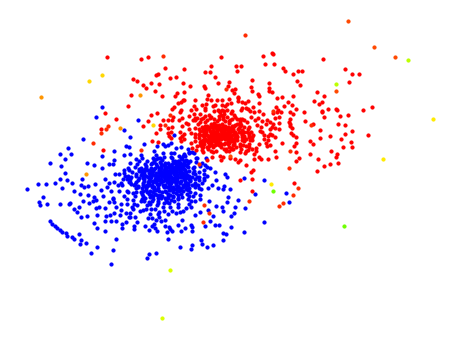

3.1088 sec
mudularity 0.42686454864499285
coverage and performance (0.922938853655618, 0.5516312324822963)


In [16]:
start = time.time()
partition = cmty.modularity_max.greedy_modularity_communities(G_undirected)
draw_communities(G_undirected, list(partition))
print(round(time.time()-start,4), "sec")
print('mudularity', cmty.modularity(G_undirected, partition))
print('coverage and performance', cmty.quality.partition_quality(G_undirected, partition))

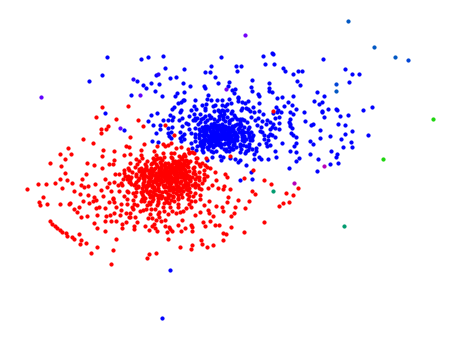

0.1765 sec
mudularity 0.42609514108566354
coverage and performance (0.9266483187746799, 0.5319551064231915)


In [17]:
start = time.time()
partition = cmty.label_propagation.label_propagation_communities(G_undirected)
draw_communities(G_undirected, list(partition))
print(round(time.time()-start,4), "sec")
print('mudularity', cmty.modularity(G_undirected, partition))
print('coverage and performance', cmty.quality.partition_quality(G_undirected, partition))

事实上，尽管本案例所绘制的图只有1000余个点，但是对本章介绍的大部分社区挖掘算法而言，已经是一个耗费大量时间的“大工程”。如常用的Girvan-Newman （只能用于无向图）算法需要的计算时间过长，我们就不再展示，有兴趣的读者可以自行尝试。